<h1>Challenge 2: Plankton Image Classification</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>April 2019</i>

## Summary
<hr style="height:1px;border:none;color:#333;background-color:#333;" />
Using the manually engineered features in a Random Forest Classifier gave the best result with a F1 Macro Score of 53%. This is significantly better than the performance of the CNN, as the highes score we were able to acheive there was . Still there is a lot of performance to gain in the CNN as we choose options which reduced our computational expenses. Increasing the size of the input to the CNN should give more information to the CNN, which should give a better classification. Continuing to adding layers to the CNN should also increase the score. An architecture like VGG16 have handled similar problems very well. 

As it was specified in the task that the purpose of this challenge was not to simply find the best-performing model, but to explore the dificulties that come with computer vision, we are content with our results.

## Intronduction
<hr style="height:1px;border:none;color:#333;background-color:#333;" /> 
70% of the oxygen in the words atmosphere is made from marine plants, which can split into two categories larger plants (such as kelp), and plankton (photoplankton and algel plankton). Plankton also forms the foundation of aquatic food webs, including those of large, commercially important fisheries. 

Traditional methods for measuring and monitoring plankton populations are time consuming and cannot scale to the granularity or scope necessary for large-scale studies. In this notebook we will compare the performance of a convolutional neural network (CNN) in which features will be learned from images alone, with a model based on manually engineered features, which have been pre-computed by experts on the topic of oceanic microbiology. The data was prepared in cooperation with the Laboratoire d’Océanographie de Villefranche, jointly run by Sorbonne Université and CNRS. Plankton images were acquired in the bay of Villefranche, weekly since 2013.

We implement the network using the keras package in Python. Throughout the task we will learn and explore common problems in computer vision. We will preprocess the images, build a CNN, evaluate the computational cost when making CNNs, and see how they respond to an augmented dataset.

## Data Exploration
<hr style="height:1px;border:none;color:#333;background-color:#333;" /> 

### Fetching Data

#### Importing libraries

In [24]:
%matplotlib inline
# For configuration and jupiter
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

import zipfile
from extract_zip import extract_zip_to_memory # function for decompressing zip in memory
from PIL import Image, ImageOps # image handling
from io import BytesIO # image handling

basepath = '/mnt/datasets/plankton/flowcam/'

#### Fetching images

In [25]:
imgFiles = extract_zip_to_memory(basepath + "imgs.zip")

100%|██████████| 243611/243611 [00:47<00:00, 5076.69it/s]


#### Fetching datasets and labels
Below we fetch data from features_native.csv.gz, and meta.csv. We also fill in the NaN values in different columns of the two dataframes, and cast values to the data type we want them. 

In [26]:
# datasets
nativeDF = pd.read_csv(basepath + 'features_native.csv.gz')
labelsDF = pd.read_csv(basepath + 'meta.csv')

native_nan_cols = ['perimareaexc', 'feretareaexc', 'cdexc', 'skeleton_area',
                   'nb1_area', 'symetrieh_area', 'symetriev_area', 'convarea_area',
                  'nb2_area', 'nb3_area']

for col_name in native_nan_cols:
    nativeDF[col_name] = nativeDF[col_name].fillna(0)

labelsDF['objid'] = labelsDF['objid'].astype(np.int64, errors='ignore')
labelsDF['level1'] = labelsDF['level1'].fillna('No_level1_name')
labelsDF['level2'] = labelsDF['level2'].fillna('No_level2_name')

print(nativeDF.isnull().sum().any())
print(labelsDF.isnull().sum().any())

False
False


#### Exploring the datasets
Data from "features_native.csv.gz" is used to look at the distribution of height and width of the images. Labels from "meta.csv" are used for training the CNN. Below we show the number of images in the dataset, max height and width of the images, and display a sample image from the "nauplii" taxonomy. 

In [27]:
print("Total amount of pictures in the complete dataset: ", nativeDF.shape[0])
print("Maximum width in the dataset: ", nativeDF.width.max())
print("Maximum height in the dataset: ", nativeDF.height.max())

Total amount of pictures in the complete dataset:  243610
Maximum width in the dataset:  972
Maximum height in the dataset:  739


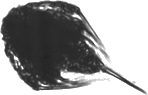

In [28]:
# display a picture
Image.open(imgFiles['imgs/32748610.jpg'])

In [29]:
print(labelsDF.loc[labelsDF["objid"] == 32748610.0].level2.values[0])

nauplii (Crustacea)


Above we can see a specimen of the "nauplii" taxonomy.

Text(77.25,0.5,'height of images')

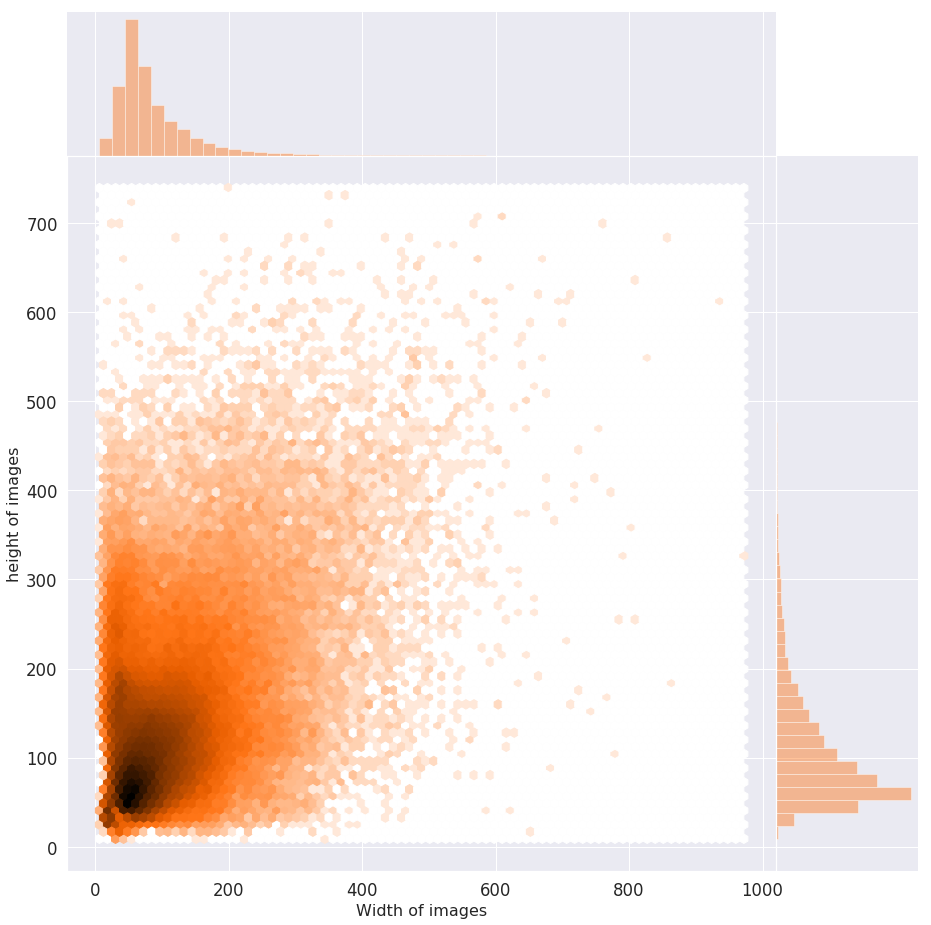

In [30]:
# Joint plot with histogram and binned scatter of the width and height of the images
cmap=plt.cm.gist_heat_r
hexmap = sns.jointplot(nativeDF.width, nativeDF.height, kind='hex', space=0, color=cmap(.3), height=13,  
                       joint_kws=dict(gridsize=80, bins="log"))
hexmap.ax_joint.set_xlabel('Width of images',  fontsize=16)
hexmap.ax_joint.set_ylabel('height of images', fontsize=16)



The above plot shows the distribution of the width and height of all the images in the dataset. We can see the majority of the images are less than 100x100 pixels (the bins used for plotting are normalized), but there are some images which are significantly bigger. The maximum width is 972 pixels and the maximum height is 739 pixels.

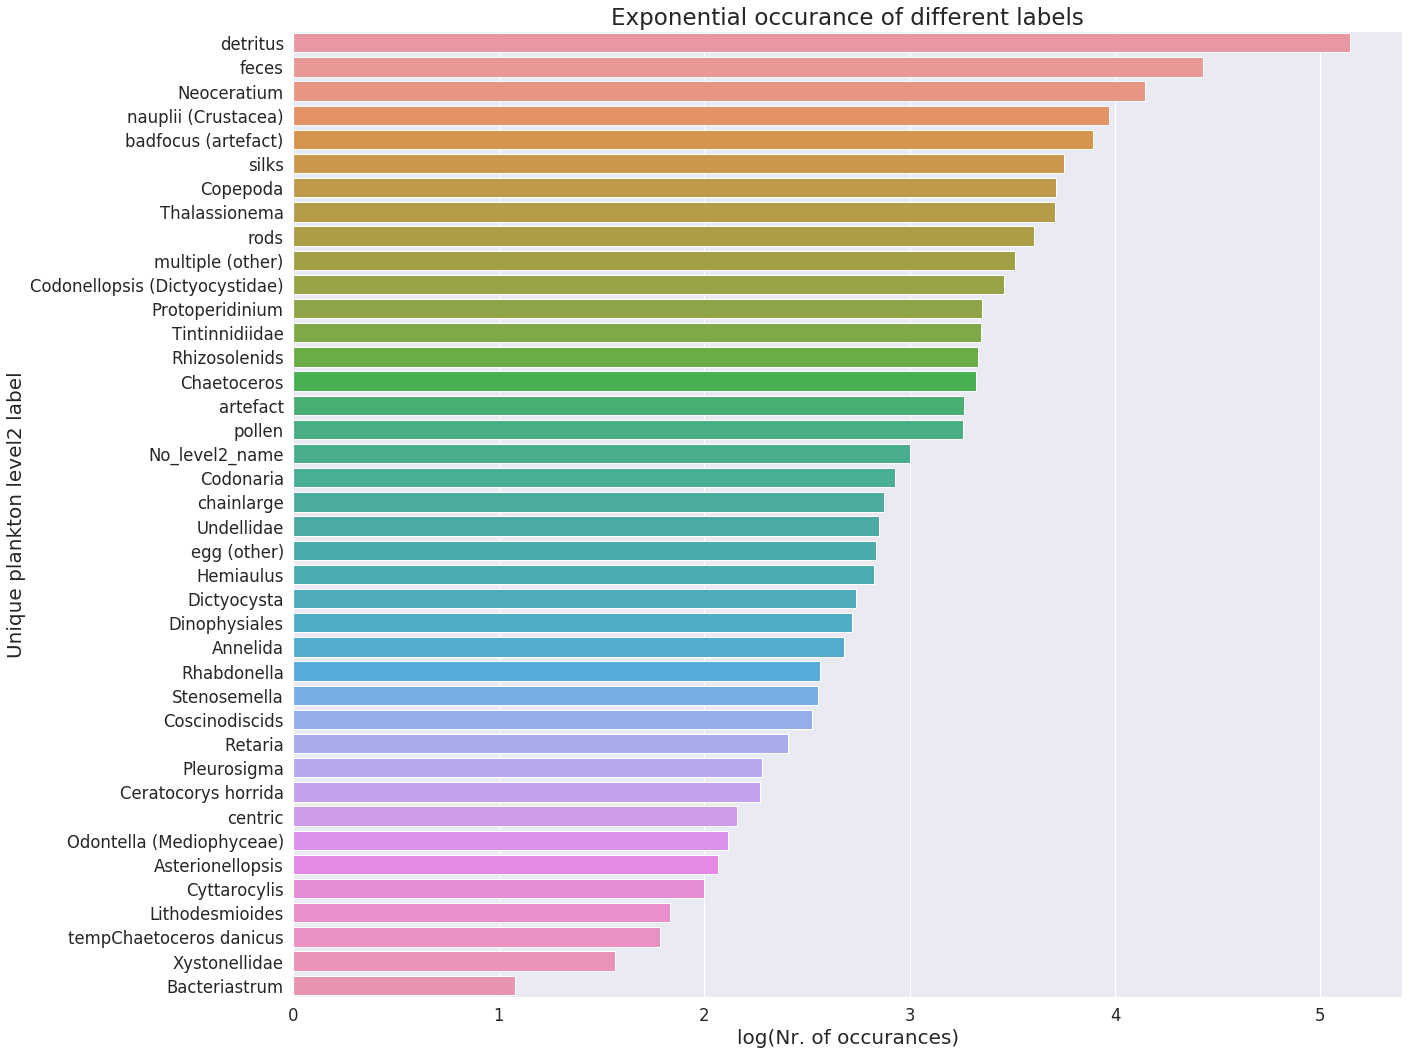

In [31]:
# Barplot
number_unique_names = labelsDF.groupby('level2', as_index=True)['id'].count()
number_unique_names.sort_values(inplace=True, ascending=False)

figure, ax = plt.subplots(figsize=(20,15))
ax = sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values))
sns.set(font_scale=1.5)

plt.ylabel('Unique plankton level2 label', fontsize= 20)
plt.xlabel('log(Nr. of occurances)', fontsize= 20)
plt.title('Exponential occurance of different labels', fontsize=23)
plt.tight_layout()

In [32]:
unique_names = labelsDF.groupby('level2', as_index=False)['id'].count()
unique_names.sort_values(inplace=True, ascending=False, by='id')

print(unique_names.iloc[0])
print(unique_names.iloc[-1])

level2    detritus
id          138439
Name: 31, dtype: object
level2    Bacteriastrum
id                   12
Name: 2, dtype: object


The plot above shows the distribution of the different labels that the different images are assigned to. The x axis is exponential as the most frequent labels would completely dominate the plot otherwise. There is a big disparity in the number of images within different label-classes. The least represented label (Bacteriastrum) has only 12 images and the most represented label (Detritus) has 138439 images. This will make the classification problem more difficult. However the plot reflects the natural prevalence of different types of plankton in nature, and this illustrates one of the fundamental problems of using CNNs as classification models in practice.

## Data Pre-processing
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

The images in the dataset have varied height and width. As we will use a convolutional neural network (CNN) we need all images to be of the same input size. We solve this by creating a blank 972x972 (max size and square) image. We then scale up the orignal image to the new size. Next the original is put in the middle of the blank 972x972 which works like padding of the original. Finally we scale the image down to the input shape we want to use for the CNN.

One of the cons of scaling the images before padding them with white pixels is that we loose the relative size parameter between different types of plankton. The alternatives would be to pad all the images up to the greatest size of 972x972, or deleting images over a certain size. The problem with scaling al the images up to 972x972 is that it would greatly increase the complexity of the NN, and most likely exceed the high memory we have available in this task. Deleting the images above a certain size is also a viable alternative, as they are few images that exceed 500 pixels in width or height. Below we show some statistics about how many "big images" there are. 

In [33]:
max_s = 500
w_500 = nativeDF[nativeDF['width'] >= max_s]['objid'].count()
h_500 = nativeDF[nativeDF['height'] >= max_s]['objid'].count()
b_500 = nativeDF[(nativeDF['width'] >= max_s) & (nativeDF['height'] >= max_s)]['objid'].count()
e_500 = w_500 + h_500 - b_500
print('Nr. of images with width greater than', max_s, 'pixels:', w_500)
print('Nr. of images with height greater than', max_s, 'pixels:', h_500)
print('Nr. of images with width and height greater than', max_s, 'pixels:', b_500)
print('Nr. of images with width or height greater than', max_s, 'pixels:', e_500)

unwanted_imgs = labelsDF[(nativeDF['width'] >= max_s) | (nativeDF['height'] >= max_s)]
print('labels-classes containing images ', unwanted_imgs['level2'].unique())

Nr. of images with width greater than 500 pixels: 294
Nr. of images with height greater than 500 pixels: 485
Nr. of images with width and height greater than 500 pixels: 66
Nr. of images with width or height greater than 500 pixels: 713
labels-classes containing images  ['silks' 'Neoceratium' 'Rhizosolenids' 'multiple (other)' 'detritus'
 'Copepoda' 'artefact' 'rods' 'feces' 'Dinophysiales' 'No_level2_name'
 'Annelida' 'badfocus (artefact)' 'nauplii (Crustacea)']


As we can see, there are 713 images that are considered as "too big", by this metric. However, we chose not to explore the alternative of deleting images further in this notebook. Below is the function we use to scale images to the correct size, and the function we use to fetch labels. We use a final size of 32x32 pixels.

In [34]:
# code inspired by https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
# Functions to preprocess images
def image_processing(key, final_size=(32, 32)):
    desired_size = 972 # max of width and height in dataset
    im_orginal = Image.open(imgFiles[key])
    old_size = im_orginal.size  # old_size[0] is in (width, height) format
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_scaled = im_orginal.resize(new_size) # scale up picture before padding to keep information
    
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    im_padded = ImageOps.expand(im_scaled, padding, fill=255) # padding of scaled picture
    
    im_final = im_padded.resize(final_size, resample=0) # resize to input size of CNN
    return np.array(im_final)

def strip(key):
    return int(key[5:-4])

def reverse_strip(objid):
    return 'imgs/' + str(objid) + '.jpg'

def fetch_label(key, lvl='level2'):
    return list(labelsDF[labelsDF['objid']==strip(key)][lvl])[0]

Below, we preprocess all the images in the original dictionary. We also attach the corresponding label to each image. After that we delete the initial dictionary imgFiles.

In [35]:
img_keys = list(imgFiles.keys())
processed_imgs = {strip(key) : [image_processing(key), fetch_label(key)] for key in tqdm(img_keys)} # tqdm

100%|██████████| 243610/243610 [19:16<00:00, 210.70it/s]


In [36]:
del imgFiles

## Data Augmentation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Earlier we discovered a disparity in the distribution of the different labels. This will make it more difficult for our Neural Network to predict the correct level 2 taxonomy for Plankton of the label-classes with fewer images. We attempt to resolve this by generating new images for the label-classes with fewer images. We do this by transposing, rotating and flipping the original image. This way we are able to generate 8 times more data in the underrepresented label-classes. We chose not to generate data by randomly cropping, rotating or scaling images, because we would loose some control of what information was lost in the image, and because our main interest is evaluating whether some data augmentation will affect the performance of the model. 

We have chosen to generate more data for images within label-classes that have less than a thousand images already. Here we collect the names of the labels-classes with less than a 1000 images, and the all the object IDs that pertain to certain label-classes. Below are the functions we use to generate new rotated, flipped and transposed duplicates of one image. Since the processed images are now numpy arrays, we can use basic numpy functions to perform said operations.

In [75]:
def generate_new_object_ids(object_id):
    stripped_key = str(object_id)
    key_lr = int('8' + stripped_key[1:])
    key_ud = int('1' + stripped_key[1:])
    key_90 = int('2' + stripped_key[1:])
    key_180 = int('4' + stripped_key[1:])
    key_270 = int('5' + stripped_key[1:])
    key_t1 = int('6' + stripped_key[1:])
    key_t2 = int('7' + stripped_key[1:])
    return {'lr' : key_lr, 'ud' : key_ud, '90' : key_90, '180' : key_180,
                '270' : key_270, 't1' : key_t1, 't2' : key_t2}

def generate_duplicates(object_id, image_files=processed_imgs):
    # Fetching and making numpy array of original object
    img_np_array = image_files[object_id][0]

    # Generating copies of data using numpy functions for flipping, rotating and transposing
    # Flip image up down
    img_flipped_ud = np.flip(img_np_array, 0)
    # Flip image left right
    img_flipped_lr = np.flip(img_np_array, 1)
    # Rotate image 90 degrees
    img_rot_90 = np.rot90(img_np_array, k=1)
    # Rotate image 180 degrees
    img_rot_180 = np.rot90(img_np_array, k=2)
    # Rotate image 270 degrees
    img_rot_270 = np.rot90(img_np_array, k=3) 
    # Transpose image (flip it around axis going from upper left corner to bottom right)
    img_tran_1 = np.transpose(img_np_array) 
    # Flip image around axis going from upper right corner to bottom left
    img_tran_2 = np.flip(np.transpose(np.flip(img_np_array, 1)), 1) 
    
    # Generating new keys
    key_dict = generate_new_object_ids(object_id)
    # Fetching label
    lbl = list(labelsDF[labelsDF['objid']==object_id]['level2'])[0]
    # Updating dictionary of images with new data
    image_files.update({key_dict['ud'] : [img_flipped_ud, lbl], key_dict['lr'] : [img_flipped_lr, lbl], 
                      key_dict['90'] : [img_rot_90, lbl], key_dict['180'] : [img_rot_180, lbl], 
                      key_dict['270'] : [img_rot_270, lbl], key_dict['t1'] : [img_tran_1, lbl], 
                      key_dict['t2'] : [img_tran_2, lbl]})
    
    return image_files

In the cell below, we find all the object IDs that pertain to images, within a label-class with less than 1000 images. 

In [76]:
# Fetching the object ids that pertain to specific labels
unique_names = list(number_unique_names.index)
original_objid_dict = {}
# Fetching the label-classes we want to generate more data within
labels_to_multiply = []
labels_not_to_multiply = []

critical_number_of_images = 1000

for name in unique_names:
    objid_labels = list(labelsDF.loc[labelsDF['level2'] == name, 'objid'])
    original_objid_dict.update({name : objid_labels})
    
    # Find labels that we want to generate more data within
    if len(objid_labels) < critical_number_of_images:
        labels_to_multiply.append(name)
    else:
        labels_not_to_multiply.append(name)

Here we loop through the different labels we want to produce more data for, and produce "duplicates" for every object ID in that label-class. However, notice that we created two separate dictionaries. One dictionary contains only the object IDs of the original images (original_objid_dict), and the other dictionary contains the object IDs of all the the original, and the generated images (augmented_objid_dict). We will use these later when we want to train our model on the original dataset, and the augmented dataset. 

In [77]:
def augment_dataset(image_files=processed_imgs):
    # To keep track of total amount of images created
    total_nr = 0
    # We make a new dictionary to keep track of the augmented data, in relation to the original data
    augmented_objid_dict = {}

    for label in labels_to_multiply:
        # Fetch object IDs pertaining to one specific label
        object_ids = original_objid_dict[label]

        #print('For label:', label[:4], 'we generate', len(object_ids)*8, 'new images')
        total_nr += len(object_ids)*8

         # Create a list of the object IDs of the newly created images so we can feed them into augmented_objid_dict
        object_ids_new = []

        # Create new data
        for objid in object_ids:
            image_files = generate_duplicates(objid)
            object_ids_new += list(generate_new_object_ids(objid).values())

        # Append new object IDs to augmented_objid_dict
        augmented_objid_dict.update({label : object_ids + object_ids_new})

    for label in labels_not_to_multiply:
        augmented_objid_dict.update({label : original_objid_dict[label]})
    
    print('Total nr. of new images produced:', total_nr)
    print('new length of image dictionary:', len(list(processed_imgs.keys())))
    return image_files, augmented_objid_dict

processed_imgs, augmented_objid_dict = augment_dataset()
nr_keys_in_augmented = 0
for label in list(augmented_objid_dict.keys()):
    nr_keys_in_augmented += len(augmented_objid_dict[label])

print('Number of object ids in the augmented dataset:', nr_keys_in_augmented)

Total nr. of new images produced: 60632
new length of image dictionary: 296663
Number of object ids in the augmented dataset: 296663


Now, let us have a look at what the new data distribution within label-classes looks like.

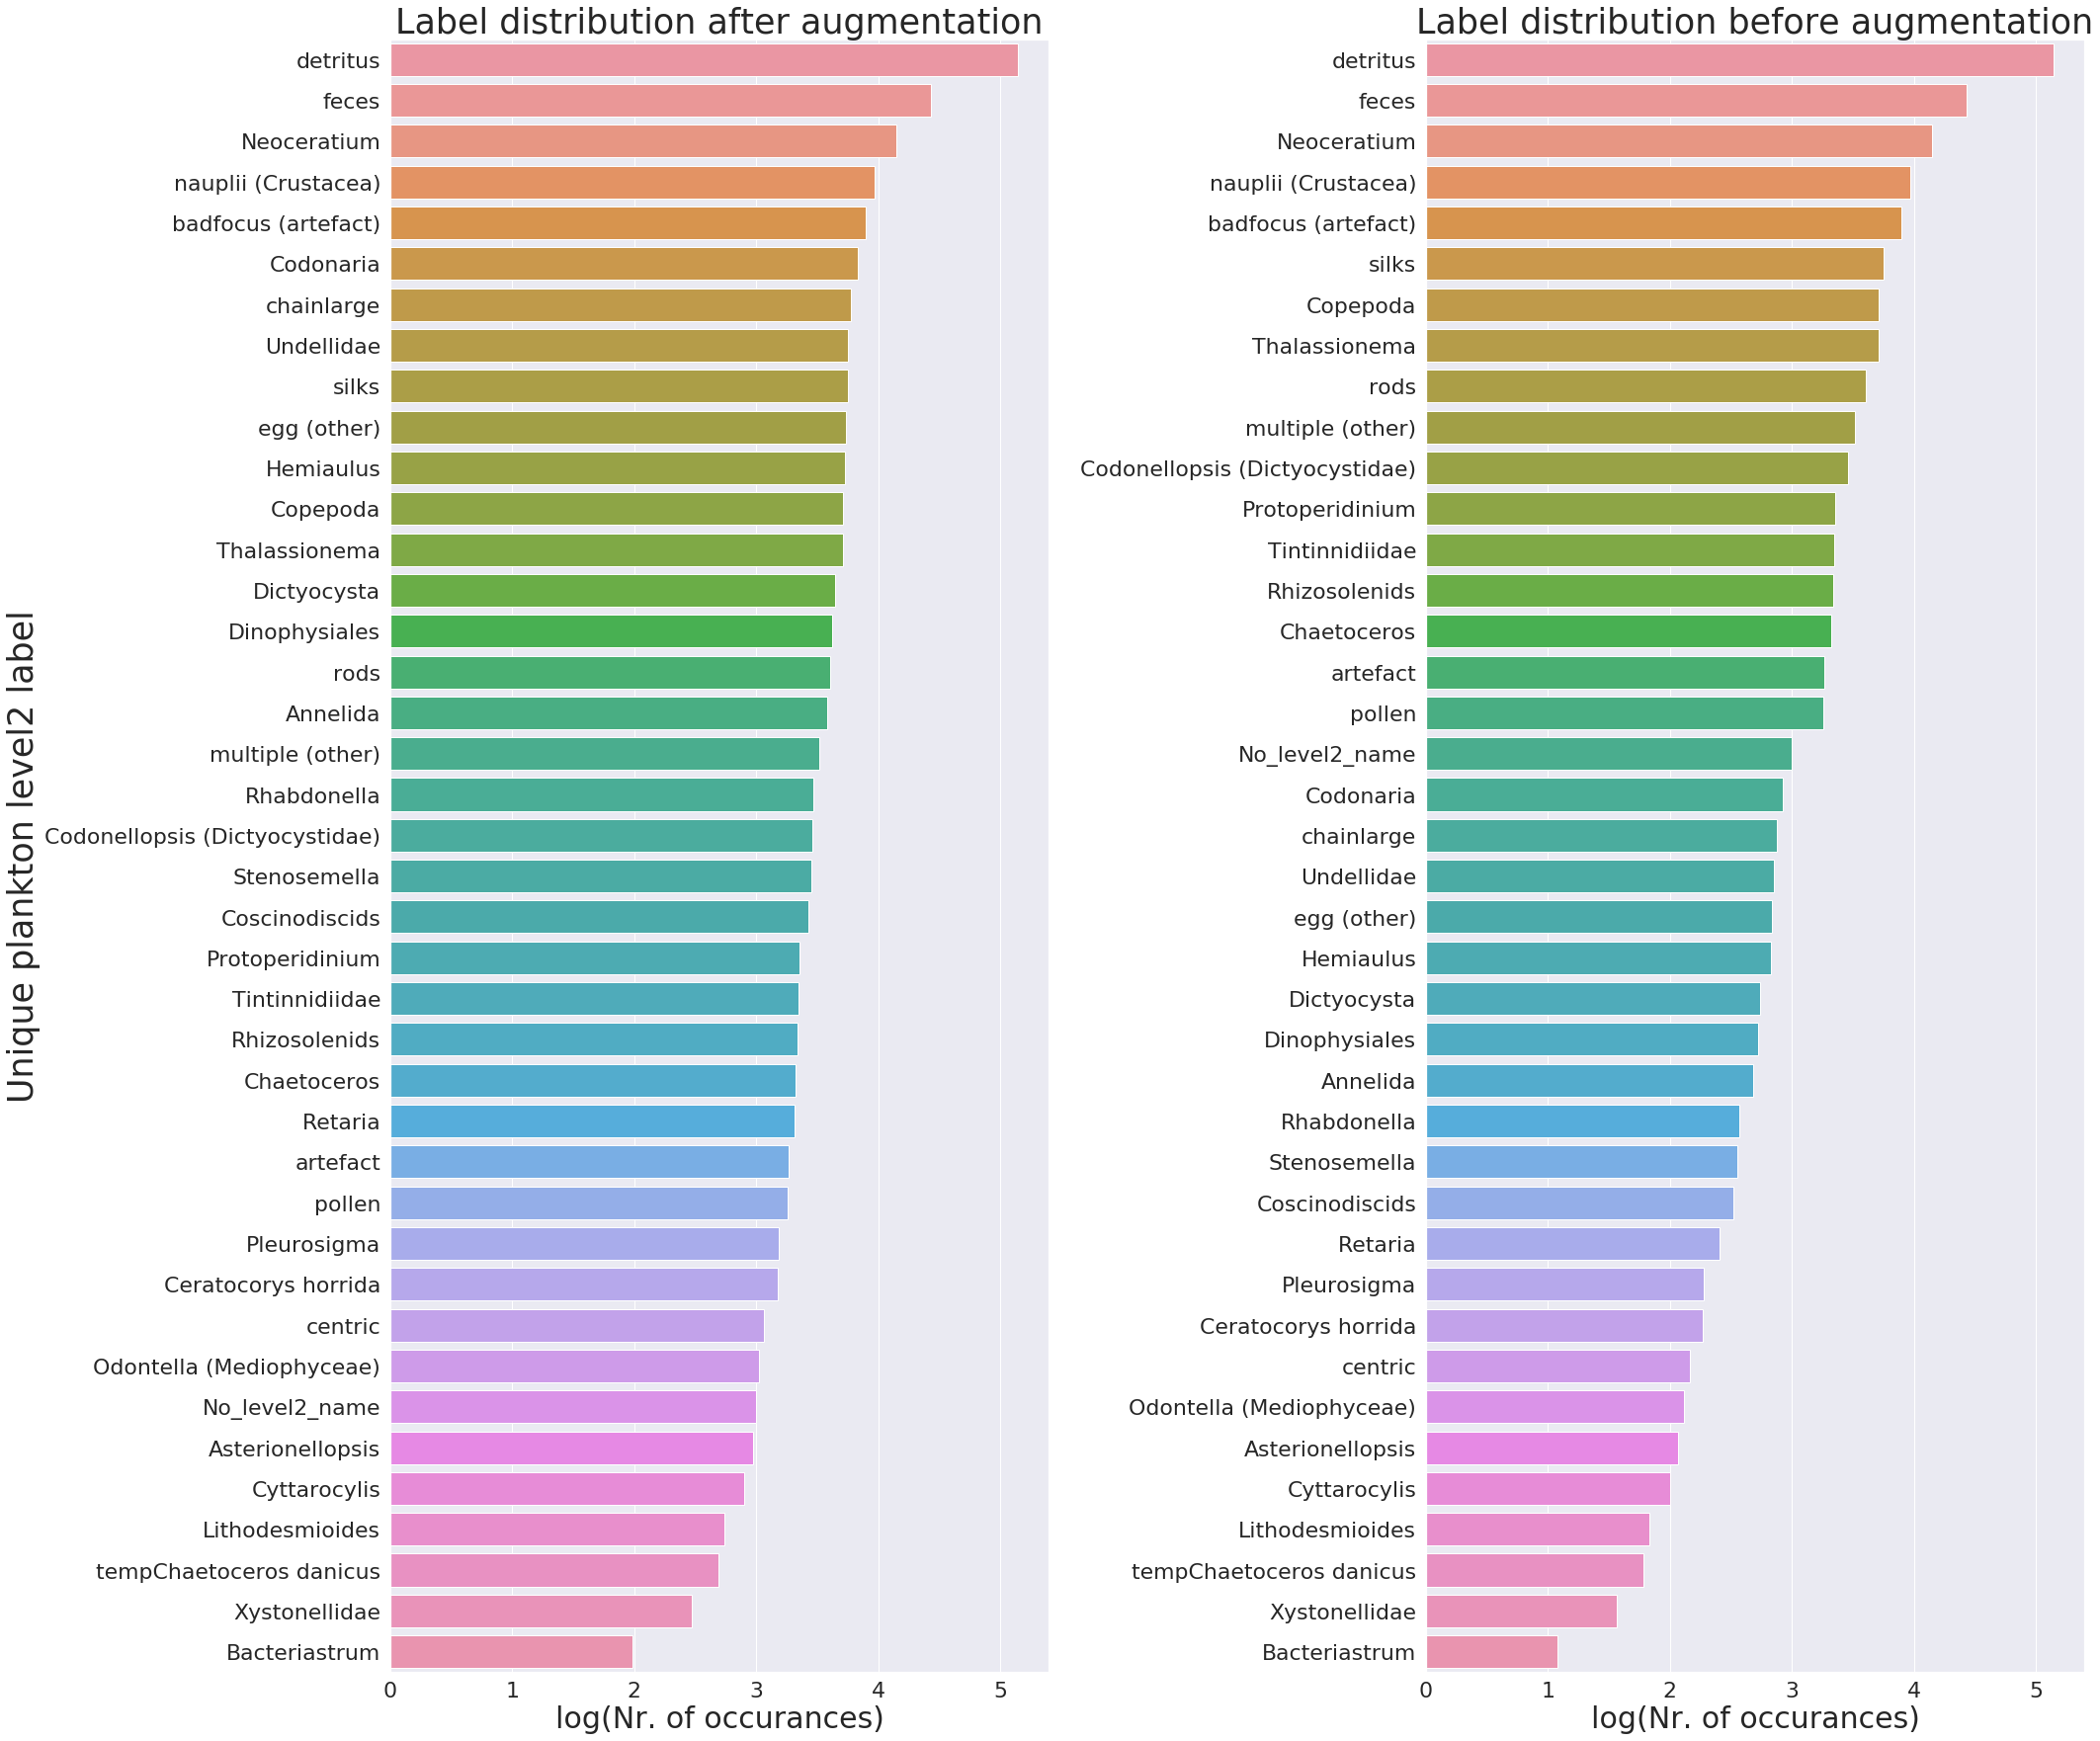

In [79]:
list_labels = []
for objid in list(processed_imgs.keys()):
    list_labels.append([objid, processed_imgs[objid][1]])

labels_objid_dict = {'objid' : [element[0] for element in list_labels],
                     'label' : [element[1] for element in list_labels]}
labelDF = pd.DataFrame.from_dict(labels_objid_dict)

number_unique_names2 = labelDF.groupby('label', as_index=True)['objid'].count()
number_unique_names2.sort_values(inplace=True, ascending=False)

fig = plt.figure(figsize=(30,25))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.barplot(y=number_unique_names2.index, x=np.log10(number_unique_names2.values), ax=ax1)
sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values), ax=ax2)

sns.set(font_scale=2)

ax1.set_ylabel('Unique plankton level2 label', fontsize=35)
ax1.set_xlabel('log(Nr. of occurances)', fontsize=30)
ax1.set_title('Label distribution after augmentation', fontsize=35)

ax2.set_ylabel('')
ax2.set_xlabel('log(Nr. of occurances)', fontsize=30)
ax2.set_title('Label distribution before augmentation', fontsize=35)
plt.tight_layout()

On the left is a bar plot of the exponential distribution of the number of images within different label-classes after augmentation. And, on the right is the original distribution. Notice, that since the bars appear in descending order some of the labels have switched places. 

It made a slight difference in the data-distribution, but largest label-classes are still massively overrepresented. This is a big problem for our model. In contrast to regression models where we are trying to fit a curve, classifier models follow a Bernoulli distribution. This means that the each prediction that the model does is independent of the previous predictions. Such models are hard to train when using an unbalanced dataset, especially since we are giving accuracy within different label-classes equal weighting when calculating the F1 score. We will come back to the F1 score metric later.

## Model Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" /> 

Below we implement a function to sample proportional amounts of the different label-classes when splitting the dataset into a training set, a validation set, and a test. We also implement a function that loads the images corresponding to a set of object IDs to a format that the CNN can take as an input. We use a train size of 60%, validation size of 20% and test size of 20%. 

In [39]:
# Function to split object IDs into training, validation and test datasets
def train_test_val_split(img_dict, train_size=0.6, test_size=0.2):
    train_objids = []
    test_objids = [] 
    val_objids = []
    for label in unique_names:
        object_ids = img_dict[label]
        number_train = int(len(object_ids)*train_size)
        number_test = int(len(object_ids)*test_size)
        train_objids += object_ids[:number_train]
        test_objids += object_ids[number_train:(number_train + number_test)]
        val_objids += object_ids[(number_train + number_test):]
    
    train_objids = random.sample(train_objids, len(train_objids))
    test_objids = random.sample(test_objids, len(test_objids))
    val_objids = random.sample(val_objids, len(val_objids))
    return train_objids, test_objids, val_objids

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# preprocessing found here: https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

# Function to load actual images given a set of object IDs
def autoloader(list_of_object_ids):
    X = np.array([processed_imgs[object_id][0] for object_id in list_of_object_ids])
    y = np.array([processed_imgs[object_id][1] for object_id in list_of_object_ids])
    
    # label encode target column
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # one-hot encode target column
    y = to_categorical(y)
    
    # Reshape input data to account for images only being greyscale
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    return X, y

Here we will explore a couple of different CNN structures, but first we define a custom metric function to measure the F1 score of our model after training. The F1 score is an alternative metric that is used, when one is working with a multi-class classication problem. Accuracy says what percentage the model guesses right on, however the F1 score gives the weighted average of the accuracy of the model within each label-class. 

Let $acc_1$, $acc_2$, and $acc_n$ be the accuracy of the model in label-classes 1, 2 and n. The F1 score is then calculated by

\begin{equation}
    F1 = \frac{w_1 acc_1 + w_2 acc_2 + ... w_n acc_n}{n}
\end{equation}

where $n$ is the number of label-classes, and $w_i$ is the weight given to the accuracy of class $i$. We have however chosen to weight all the classes equally, when calculating the F1 score. Below is the Python implementation of our F1 score metric. 

In [40]:
# Making metric for f1-score
# Found at https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

Below we split the data-set into training, validation and test data. We use the original data-set first and save the augmented dataset for later. 

In [41]:
train_objids, test_objids, val_objids = train_test_val_split(original_objid_dict)
# Fetch pictures and labels, corresponding to keys.
# train
X_train, y_train = autoloader(train_objids)
# validation
X_val, y_val = autoloader(val_objids)
# test
X_test, y_test = autoloader(test_objids)

In [42]:
print('--------Shape Training data--------')
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

print('\n------Shape Validation data------')
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

print('\n---------Shape Test data---------')
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

--------Shape Training data--------
X_train shape: (146151, 32, 32, 1)
y_train shape: (146151, 40)

------Shape Validation data------
X_val shape: (48751, 32, 32, 1)
y_val shape: (48751, 40)

---------Shape Test data---------
X_test shape : (48708, 32, 32, 1)
y_test shape : (48708, 40)


We set the input dimensions of the CNN, and the training parameters. We start with only one epoch to get a general idea of how well the network is performing, and use a batch size of 50 because

In [45]:
# Input dimensions
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
# Network parameters 
batch_size = 50
classes = labelsDF.level2.unique()
num_classes = labelsDF.level2.nunique()
epochs = 1

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

We use the Sequential package from keras.models to build our CNNs, as that is the package we found most intuitive to use, and explain. We start with a fairly simple CNN. A convolutional layer, with depth equal to three as our input layer and kernel equal to (3, 3), and a fully connected output layer. 

We use the "Rectified Linear Unit" (Relu) as the activation for all our layers, except the output layer, that uses "Softmax". We use Relu because it is known for performing well on interaction effects between nodes, and accounts for non-linearities in the output from the layer. We use Softmax on the output layer because we want to have the all the probabilites for a given sample to be within a certain label-class.

As a loss function we use the categorical cross-entropy function as that has proven to work well in multi-class classification problems. As a learning rate optimizer we use "Adam", as that has proven to yield the fastest descent to a global minimum. 

In [44]:
model = Sequential()

# Add layers
model.add(Conv2D(3, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# Compile model 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])

# Print model summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test the model
y_prediction = model.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score: ", K.get_value(f1_score))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 3)         30        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2700)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                108040    
Total params: 108,070
Trainable params: 108,070
Non-trainable params: 0
_________________________________________________________________
Train on 146151 samples, validate on 48751 samples
Epoch 1/1
146151/146151 [==============================] - 30s 205us/step - loss: 6.9579 - acc: 0.5683 - f1: 0.0181 - val_loss: 6.9635 - val_acc: 0.5680 - val_f1: 0.0180
F1 Score:  0.018120948


From the summary we can see that the input layer is a 30x30x3 "cube" which is flattened out to a 2700x1 layer which is fed into the output layer. From the accuracy of approximately 50% it might seem as this model is performing okay, however the F1 score is 2%. This indicates that the model is performing very well at predicting one label-class, but is not performing well in any of the other label-classes. Similar accuracy could have been acheived by only guessing Detritus every time. 

We can conclude that this model is not entirely able to capture the complexity of our problem, so we try to it expand it.  

In [54]:
del model
K.clear_session()

We add two convolutional layers, and two two fully connected layers between "Flatten" and the output layer.

In [45]:
model = Sequential()

# Add convolutional layers
model.add(Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(3, kernel_size=(3, 3), activation='relu'))

model.add(Flatten())

model.add(Dense(70, activation='relu'))
model.add(Dense(45, activation='relu')) 

model.add(Dense(num_classes, activation='softmax'))

# Compile model 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])

# Print model summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test the model
y_prediction = model.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score: ", K.get_value(f1_score))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 20)        200       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 10)        1810      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 3)         273       
_________________________________________________________________
flatten_2 (Flatten)          (None, 2028)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 70)                142030    
_________________________________________________________________
dense_3 (Dense)              (None, 45)                3195      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1840      
Total para

So this model had an improvement in F1 score, so evidently a more complex model performs better. Before going on, we save this model, as it has a pretty good performance, and is a good contendor for a final model. This we do using the keras-command:
```python
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
```
The next thing we want to do is add a drop-out layer which introduces a probability that a specific neuron up to that point can be dropped. 

In [55]:
model = Sequential()

# Add convolutional layers
model.add(Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(3, kernel_size=(3, 3), activation='relu'))

model.add(Flatten())

model.add(Dense(70, activation='relu'))
model.add(Dense(45, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(num_classes, activation='softmax'))

# Compile model 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])

# Print model summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test the model
y_prediction = model.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score: ", K.get_value(f1_score))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 20)        200       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 10)        1810      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 3)         273       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2028)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                142030    
_________________________________________________________________
dense_2 (Dense)              (None, 45)                3195      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
__________

Here we have a minor improvement in F1 score, but still an improvement. We chose to continue with this model structure, and move on to parameter optimization. Like before, we save this model as well. 

In [56]:
model.save('f1_13.h5')

## Hyper-parameter Optimisation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

When optimizing the hyperparameters of our model we have tested four other learning rate optimizers, and a couple of different dropout_rates. Because of the limited computing power and high memory available we have chosen to vary these parameters individually, and not create a complete parameter grid. We tried to use GridSearchCV from sklearn, but sadly we ran out of memory. 

In [52]:
# Function to create model
def create_model(optimizer='adam', dropout_rate=0.1):
    model = Sequential()

    # Add convolutional layers
    model.add(Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(3, kernel_size=(3, 3), activation='relu'))

    model.add(Flatten())

    model.add(Dense(70, activation='relu'))
    model.add(Dense(45, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))

    # Compile model 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1])
    return model

# Define the grid of search parameters
dropout_rates = [0.05, 0.15, 0.2, 0.25]
optimizers = ['adagrad', 'adadelta', 'adamax', 'nadam']

In [48]:
# Create model Adagrad
model0 = create_model(optimizer=optimizers[0])
# Create model Adadelta
model1 = create_model(optimizer=optimizers[1])
# Create model Adamax
model2 = create_model(optimizer=optimizers[2])
# Create model Nadam
model3 = create_model(optimizer=optimizers[3])

# Train model Adagrad
model0.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test model Adagrad
y_prediction = model0.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score Adagrad: ", K.get_value(f1_score))

# Train model Adadelta
model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test model Adadelta
y_prediction = model1.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score Adadelta: ", K.get_value(f1_score))

# Train model Adam
model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test model Adam
y_prediction = model2.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score Adamax: ", K.get_value(f1_score))

# Train model Adamax
model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test model Adamax
y_prediction = model3.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score Nadam: ", K.get_value(f1_score))

Train on 146151 samples, validate on 48751 samples
Epoch 1/1
146151/146151 [==============================] - 314s 2ms/step - loss: 1.4474 - acc: 0.6239 - f1: 0.0435 - val_loss: 1.1691 - val_acc: 0.6755 - val_f1: 0.0674
F1 Score Adagrad:  0.09332751
Train on 146151 samples, validate on 48751 samples
Epoch 1/1
146151/146151 [==============================] - 315s 2ms/step - loss: 1.4162 - acc: 0.6327 - f1: 0.0503 - val_loss: 4.5115 - val_acc: 0.2443 - val_f1: 0.0168
F1 Score Adadelta:  0.03451827
Train on 146151 samples, validate on 48751 samples
Epoch 1/1
146151/146151 [==============================] - 311s 2ms/step - loss: 1.4063 - acc: 0.6222 - f1: 0.0439 - val_loss: 1.1101 - val_acc: 0.6808 - val_f1: 0.0687
F1 Score Adamax:  0.094216764
Train on 146151 samples, validate on 48751 samples
Epoch 1/1
146151/146151 [==============================] - 313s 2ms/step - loss: 14.3360 - acc: 0.1106 - f1: 0.0049 - val_loss: 14.3367 - val_acc: 0.1105 - val_f1: 0.0049
F1 Score Nadam:  0.00497920

With an F1 score of 13% the Adam optimizer still performs best of all the optimizers so we use that further when experimenting with different dropout rates.

In [51]:
del model0, model1, model2, model3
K.clear_session

<function keras.backend.tensorflow_backend.clear_session()>

In [54]:
# Create model for dropout_rate = 0.05
model0 = create_model(dropout_rate=dropout_rates[0])
# Create model for dropout_rate = 0.15
model1 = create_model(dropout_rate=dropout_rates[1])
# Create model for dropout_rate = 0.20
model2 = create_model(dropout_rate=dropout_rates[2])
# Create model for dropout_rate = 0.25
model3 = create_model(dropout_rate=dropout_rates[3])


# Train model dropout_rate = 0.05
model0.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test model dropout_rate = 0.05
y_prediction = model0.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score with dropout_rate = 0.05: ", K.get_value(f1_score))

# Train model dropout_rate = 0.15
model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test model dropout_rate = 0.15
y_prediction = model1.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score with dropout_rate = 0.15: ", K.get_value(f1_score))

# Train model dropout_rate = 0.20
model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test model dropout_rate = 0.20
y_prediction = model2.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score with dropout_rate = 0.20: ", K.get_value(f1_score))

# Train model dropout_rate = 0.25
model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test model dropout_rate = 0.25
y_prediction = model3.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score with dropout_rate = 0.25: ", K.get_value(f1_score))

Train on 146151 samples, validate on 48751 samples
Epoch 1/1
146151/146151 [==============================] - 236s 2ms/step - loss: 1.3061 - acc: 0.6395 - f1: 0.0533 - val_loss: 1.0432 - val_acc: 0.6963 - val_f1: 0.0797
F1 Score with dropout_rate = 0.05:  0.11633782
Train on 146151 samples, validate on 48751 samples
Epoch 1/1
146151/146151 [==============================] - 220s 2ms/step - loss: 4.2762 - acc: 0.5063 - f1: 0.0376 - val_loss: 1.1394 - val_acc: 0.6818 - val_f1: 0.0686
F1 Score with dropout_rate = 0.15:  0.09362101
Train on 146151 samples, validate on 48751 samples
Epoch 1/1
146151/146151 [==============================] - 218s 1ms/step - loss: 1.4032 - acc: 0.6285 - f1: 0.0467 - val_loss: 1.1209 - val_acc: 0.6851 - val_f1: 0.0738
F1 Score with dropout_rate = 0.20:  0.10802536
Train on 146151 samples, validate on 48751 samples
Epoch 1/1
146151/146151 [==============================] - 217s 1ms/step - loss: 1.3824 - acc: 0.6298 - f1: 0.0465 - val_loss: 1.0752 - val_acc: 0.6

With an F1-score 0.13%, the dropout rate of 0.1 still performs best, hence we continue with the last model we saved, before we began with hyper-parameter optimization and begin evaluating our model. 

## Model Evaluation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />  
We start by evaluating our model on the augmented dataset we made before. We start with one epoch, but then crank it up to ten epochs to really see what accuracies we can acheive.

In [81]:
del model0, model1, model2, model3
K.clear_session()

train_objids, test_objids, val_objids = train_test_val_split(augmented_objid_dict)
# Fetch pictures and labels, corresponding to keys.
# train
X_train, y_train = autoloader(train_objids)
# validation
X_val, y_val = autoloader(val_objids)
# test
X_test, y_test = autoloader(test_objids)

print('--------Shape Training data--------')
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

print('\n------Shape Validation data------')
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

print('\n---------Shape Test data---------')
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

--------Shape Training data--------
X_train shape: (177980, 32, 32, 1)
y_train shape: (177980, 40)

------Shape Validation data------
X_val shape: (59365, 32, 32, 1)
y_val shape: (59365, 40)

---------Shape Test data---------
X_test shape : (59318, 32, 32, 1)
y_test shape : (59318, 40)


In [83]:
# Input dimensions
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
# Network parameters 
batch_size = 50
classes = labelsDF.level2.unique()
num_classes = labelsDF.level2.nunique()
epochs = 1

from keras.models import load_model

model = load_model('f1_13.h5', custom_objects={'f1' : f1})
model.add(Dropout(0.1))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1])

model.summary()
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 20)        200       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 10)        1810      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 3)         273       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2028)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                142030    
_________________________________________________________________
dense_2 (Dense)              (None, 45)                3195      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
__________

In [84]:
y_pred = model.predict(X_test)
f1_score = f1(y_test, y_pred)
print("F1 Score: ", K.get_value(f1_score))

F1 Score:  0.18993911


Now the F1 score has improved to 19%, so augmenting the dataset does affect the performance of the model. We now want to see how accuracy we can get with epochs.

In [ ]:
model.fit(X_train, y_train, epochs=6, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))
y_pred = model.predict(X_test)
f1_score = f1(y_test, y_pred)
print("F1 Score: ", K.get_value(f1_score))

Train on 177980 samples, validate on 59365 samples
Epoch 1/6
177980/177980 [==============================] - 262s 1ms/step - loss: 2.6585 - acc: 0.5823 - f1: 0.1200 - val_loss: 1.1927 - val_acc: 0.6451 - val_f1: 0.1407
Epoch 2/6
 42250/177980 [======>.......................] - ETA: 3:07 - loss: 2.6163 - acc: 0.5982 - f1: 0.1342

### Classification of Plankton based on features 

In [4]:
y = labelsDF['level2'] 
X = nativeDF

from sklearn.model_selection import train_test_split

# Divide train data into train and validation sets

seed = 42
test_size = 0.20

X_train_csv, X_test_csv, y_train_csv, y_test_csv  = train_test_split(X, y, test_size = test_size, random_state = seed)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


model_csv = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='entropy')
model_csv.fit(X_train_csv, y_train_csv)
model_predictions_csv = model_csv.predict(X_test_csv)
model_f1_csv = f1_score(y_test_csv, model_predictions_csv, average="macro", labels=np.unique(model_predictions_csv))
print("Final F1 Score: ", model_f1_csv)

Final F1 Score:  0.534152464111891


## Conclusion
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

In conclusion our CNN had a final F1 score of XX%, and the model based on hand-crafted features given by Laboratoire d’Océanographie de Villefranche had and F1 score of 53%. This shows that it is challenging to create a CNN that outperforms a predictive model based on manual feature extraction done by experts in a field. However that does not mean that all other CNNs would perform worse as well.

There are some parts our approach that were limited by time, and available resources. If we had had a more suitable hardware for image processing available, such as a GPU, we could have scaled up the images of the plankton to 100x100, 300x300 or higher which would have yielded a better resolution of the images and more features for a CNN to work from. 

We could also have done a more exhaustive search during the different learning rate optimizers. We considered exclusively optimizers with adaptible learning rate, but we could also have looked other optimizers such as RMSProp and basic SDG, and done a grid search over learning rate, momentum and weight decay. 

We could also have explored the effect of all the other hyperparameters such as batch size, weights initialization, activation function, number of neurons in the hidden layers, and so on.